# **Proyek Akhir : Image Classification Model Deployment**

# **DATA DIRI**

* Nama      : Karlina Surya Witanto
* ID        : M014V6051
* PT        : Universitas Udayana
* Email     : gabriella.linatan@gmail.com
* Email SIB : m014v6051@dicoding.org

In [8]:
import numpy as np
import pandas as pd
import os
import cv2
import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.utils import class_weight, shuffle
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense,Conv2D,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [9]:
! pip install -q kaggle

In [10]:
!mkdir -p ~/.kaggle


In [11]:
!cp kaggle.json ~/.kaggle/


In [12]:
!chmod 600 ~/.kaggle/kaggle.json

In [13]:
!kaggle datasets download -d alessiocorrado99/animals10


 98% 571M/586M [00:03<00:00, 167MB/s]
100% 586M/586M [00:03<00:00, 158MB/s]


In [14]:
import zipfile
 
zip_ref = zipfile.ZipFile('/content/animals10.zip','r')
zip_ref.extractall('/content/file')
zip_ref.close()

In [15]:
!rm *.zip


In [16]:
!pip install split_folders


# Loading Data From Local

In [17]:
foldernames = os.listdir('/content/file/raw-img')
categories = []
files = []
for k, folder in enumerate(foldernames):
    filenames = os.listdir("/content/file/raw-img/" + folder);
    for file in filenames:
        files.append("/content/file/raw-img/" + folder + "/" + file)
        categories.append(k)
        
df = pd.DataFrame({
    'filename': files,
    'category': categories
})
train_df = pd.DataFrame(columns=['filename', 'category'])


In [18]:
for i in range(3):
    train_df = train_df.append(df[df.category == i].iloc[:1200,:])

train_df.head()
train_df = train_df.reset_index(drop=True)
train_df

,filename,category
0,/content/file/raw-img/cavallo/OIP-u5myOAnI9X1w...,0
1,/content/file/raw-img/cavallo/OIP-5wH9vPk_DpqU...,0
2,/content/file/raw-img/cavallo/OIP-KT-tDe-ywWys...,0
3,/content/file/raw-img/cavallo/OIP-4HLihQd4NQsr...,0
4,/content/file/raw-img/cavallo/OIP-jKbtBe4c4_ty...,0
...,...,...
3595,/content/file/raw-img/scoiattolo/OIP-SELGUyWrd...,2
3596,/content/file/raw-img/scoiattolo/OIP-cgGgTTt1s...,2
3597,/content/file/raw-img/scoiattolo/OIP-J59IMu0Xv...,2
3598,/content/file/raw-img/scoiattolo/OIP-vEv83DoHn...,2


In [19]:
y = train_df['category']
x = train_df['filename']
y = train_df['category']

x, y = shuffle(x, y, random_state=8)

# Resize Image

In [20]:
def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

images = []
with tqdm(total=len(train_df)) as pbar:
    for i, file_path in enumerate(train_df.filename.values):
        #read image
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #resize
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #out put 224*224px 
        img = img[16:240, 16:240]
        images.append(img)
        pbar.update(1)

images = np.array(images)

  0%|          | 0/3600 [00:00<?, ?it/s]

# Splitting Data

In [21]:
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)
split_val = int(round(0.2*len(y)))
x_train = x[split_val:]
y_train = y[split_val:]
x_test = x[:split_val]
y_test = y[:split_val]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

img_rows, img_cols, img_channel = 224, 224, 3
name_animal = []
for i in range(3):
  path = train_df[train_df.category == i].values[2]
  if path[0].split('/')[-2] == 'cavallo':
      name_animal.append('horse')
  elif path[0].split('/')[-2] == 'farfalla':
      name_animal.append('butterfly')
  elif path[0].split('/')[-2] == 'mucca':
      name_animal.append('cow')


In [22]:
print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (2880, 224, 224, 3)
y_train (2880, 3)
x_test (720, 224, 224, 3)
y_test (720, 3)


# Fixing data shape


In [23]:
img_shape=(img_rows, img_cols, img_channel)

# Building model

In [24]:
model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=img_shape),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPool2D(2,2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=3e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

## Setting up parameter

In [25]:
batch_size = 32
epochs = 100

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(x_train)

# Creating callbacks function

In [26]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.85) and (logs.get('accuracy')>0.85):
      print('\nAkurasi telah mencapai > 85%')
      self.model.stop_training = True
myCallbacks = myCallback()

In [27]:
%load_ext tensorboard


In [28]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# Start training

In [30]:
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[myCallbacks, tensorboard_callback])

Epoch 1/100
90/90 [==============================] - 72s 430ms/step - loss: 0.9007 - accuracy: 0.5611 - val_loss: 0.8812 - val_accuracy: 0.6194
Epoch 2/100
90/90 [==============================] - 37s 409ms/step - loss: 0.6758 - accuracy: 0.7281 - val_loss: 0.5503 - val_accuracy: 0.7681
Epoch 3/100
90/90 [==============================] - 36s 404ms/step - loss: 0.5960 - accuracy: 0.7656 - val_loss: 0.8140 - val_accuracy: 0.6819
Epoch 4/100
90/90 [==============================] - 36s 400ms/step - loss: 0.5176 - accuracy: 0.7927 - val_loss: 0.6554 - val_accuracy: 0.7431
Epoch 5/100
90/90 [==============================] - 36s 399ms/step - loss: 0.4739 - accuracy: 0.8104 - val_loss: 0.5623 - val_accuracy: 0.7778
Epoch 6/100
90/90 [==============================] - 36s 401ms/step - loss: 0.4303 - accuracy: 0.8319 - val_loss: 0.4636 - val_accuracy: 0.8069
Epoch 7/100
90/90 [==============================] - 36s 399ms/step - loss: 0.4337 - accuracy: 0.8306 - val_loss: 0.4612 - val_accuracy:

# Creating plot

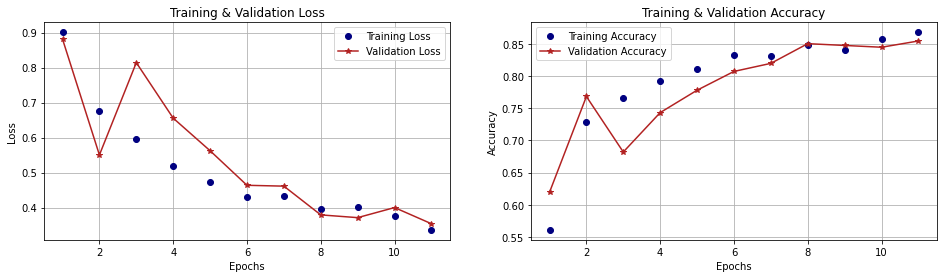

In [31]:
#print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(epochs,history.history['accuracy'][epochs-1],history.history['val_accuracy'][epochs-1]))
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals
show_plots(history.history)

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmprc31aprw/assets


In [33]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)